# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def calibrate_camera():
    
    files = glob.glob('camera_cal/calibration*.jpg')
    checkerboardsize = (9,6)
    
    h_count,v_count = checkerboardsize
    
    objp = np.zeros((v_count*h_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:h_count, 0:v_count].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    for idx, fname in enumerate(files):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (h_count,v_count), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    image = cv2.imread(files[0])
    image_size = (image.shape[1], image.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)

    return mtx, dist

cameraMatrix, distortionCoefficients = calibrate_camera()

def undistort(image):
  
    dst = cv2.undistort(
        image, 
        cameraMatrix, 
        distortionCoefficients, 
        None, 
        cameraMatrix)
    
    return dst


def test_undistort(file):
    
    img = cv2.imread(file)
    dst = undistort(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    

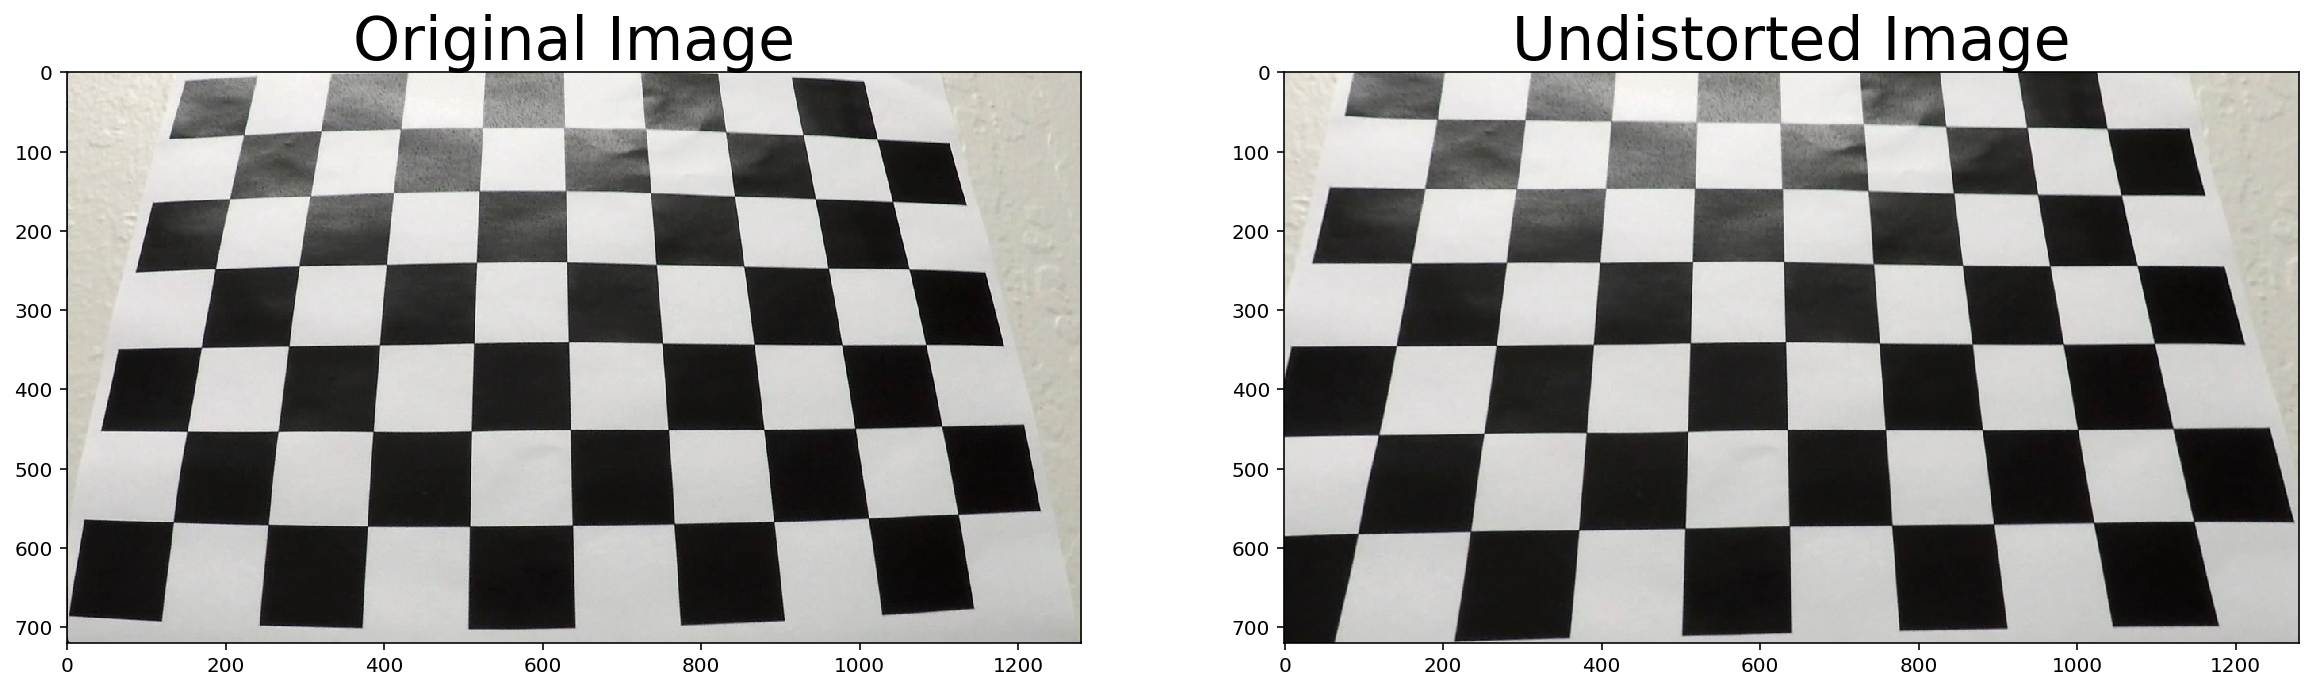

In [2]:
test_undistort('camera_cal/calibration3.jpg')

# Distortion Correction

In [3]:
from time import sleep

def perspective_transforms():
    
    src = np.float32([
        [592,450], #top_left
        [686,450], #top_right
        [1074,693], #bottom_right
        [231,693] #bottom_left
        ])

    dst = np.float32([
        [250,0], #top_left
        [1080,0], #top_right
        [1070,678], #bottom_right
        [250,678] #bottom_left
        ])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

TransformMatrix,InverseTransformMatrix = perspective_transforms()

def transform(image):
    result = cv2.warpPerspective(image, TransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result

def reverse(image):
    result = cv2.warpPerspective(image, InverseTransformMatrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    return result


def test_transform(file):
    
    img = cv2.imread(file)
  
    img = undistort(img)
    
    warped = transform(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=30) 
    plt.imshow(warped)
    

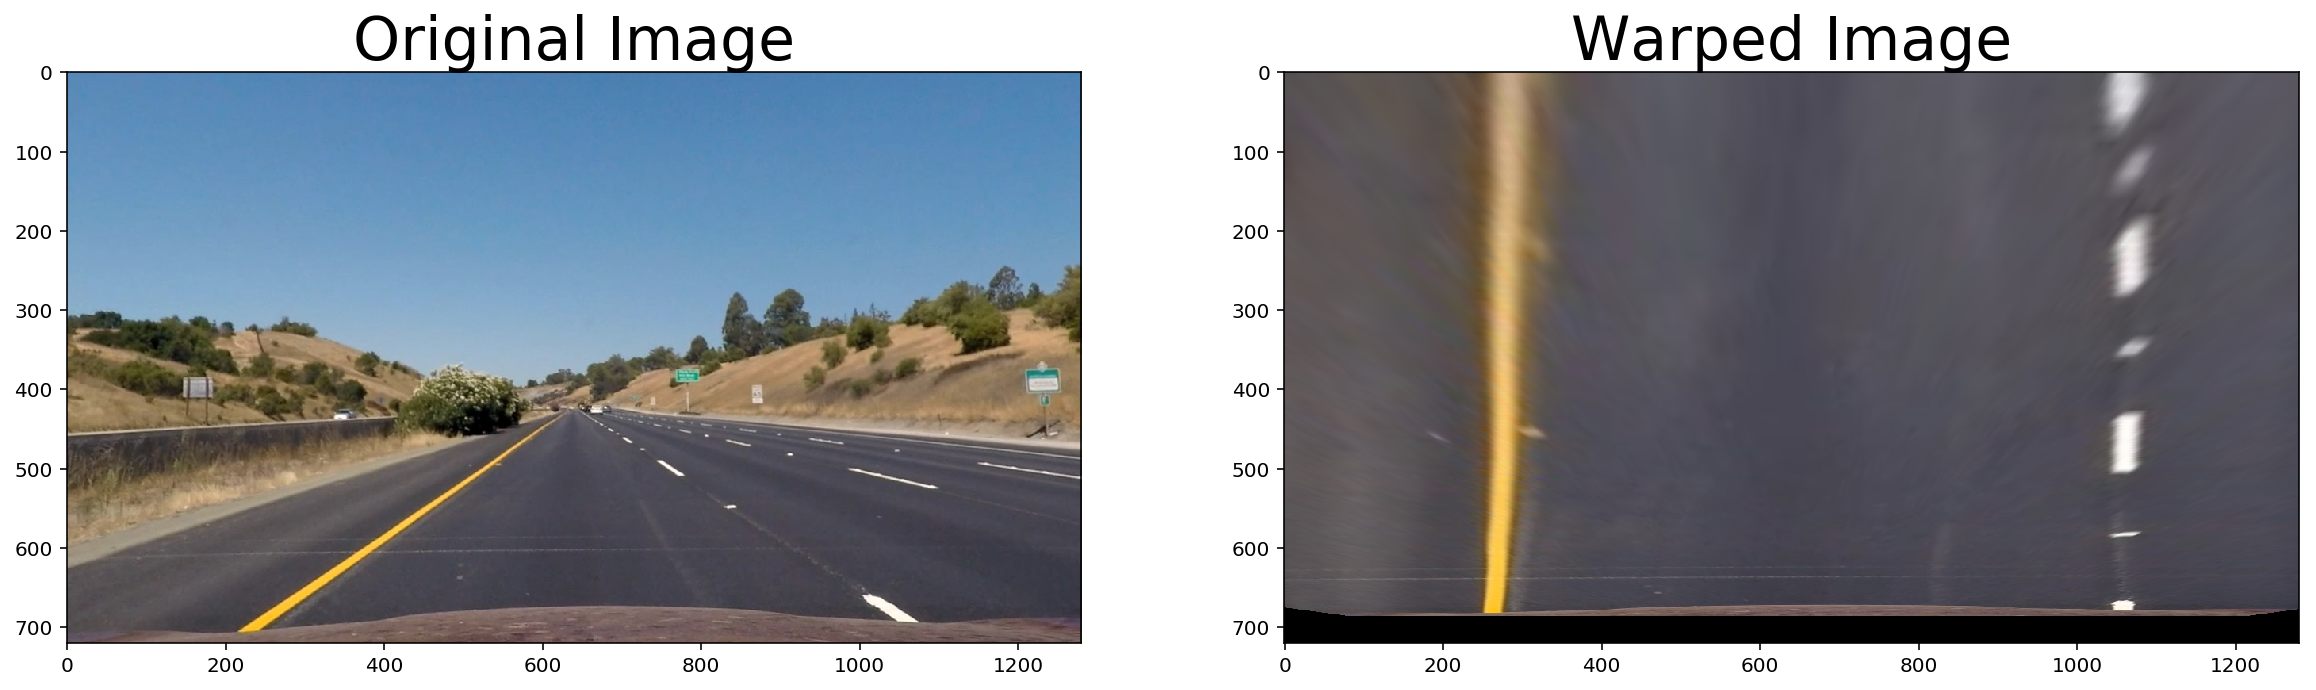

In [4]:
test_transform('test_images/straight_lines1.jpg')   

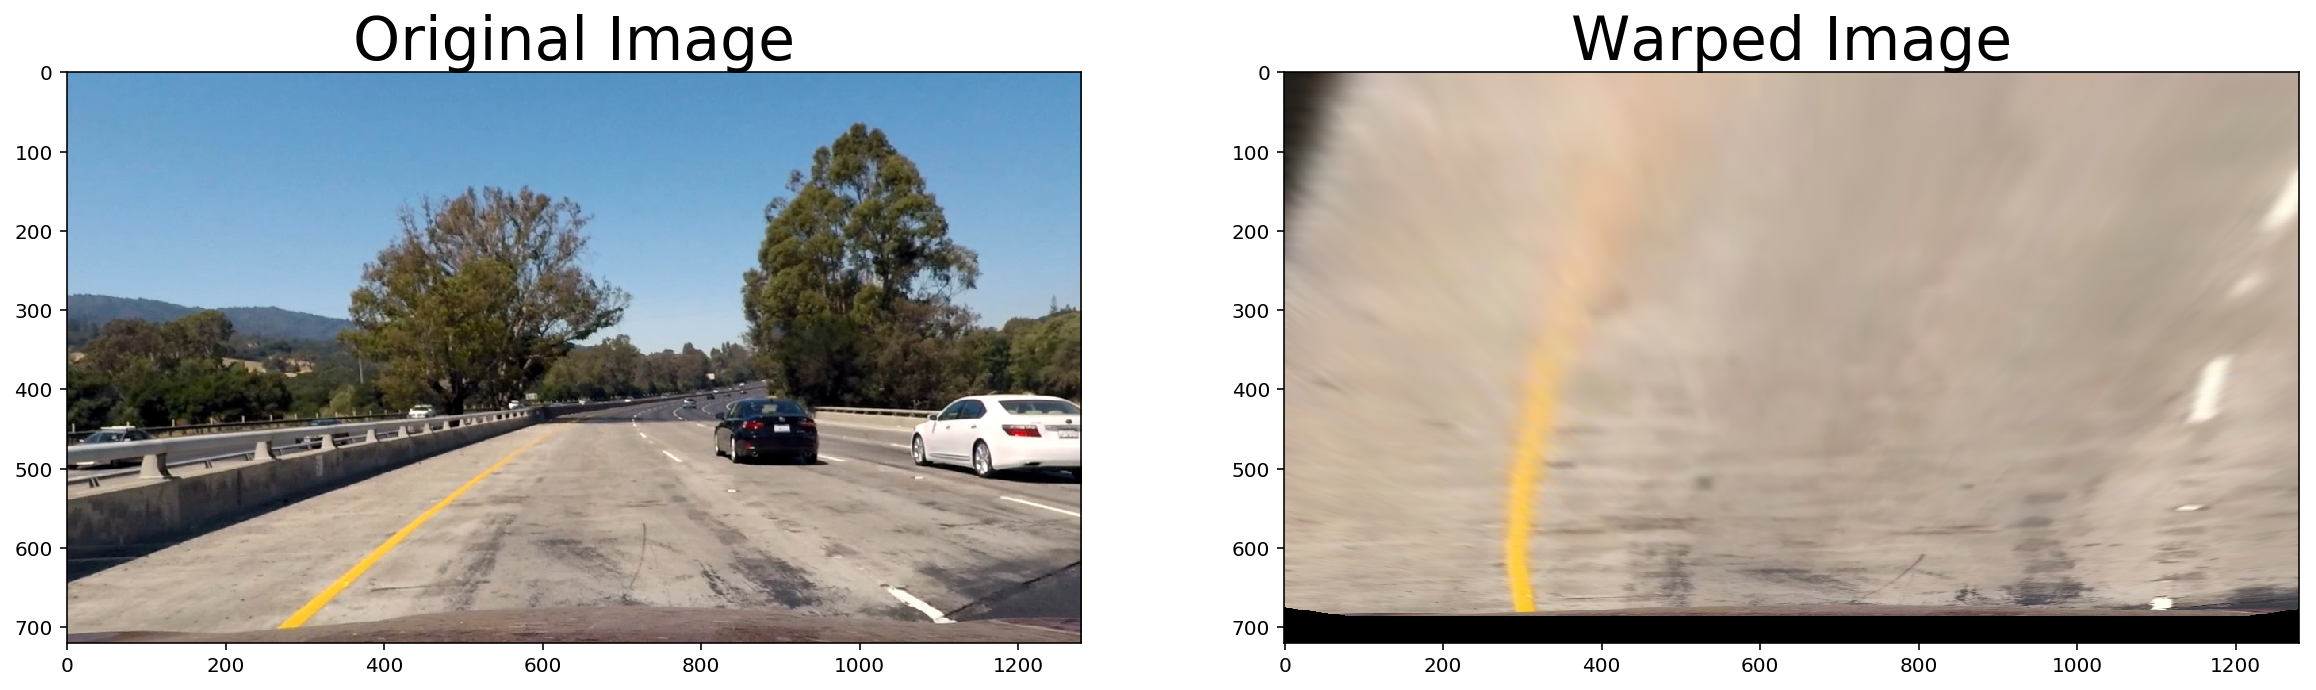

In [5]:
test_transform('test_images/test1.jpg')   

In [6]:
def gradient_axis_mask(img, axis='x', sobel_kernel=3, thresh=(0, 255)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    dx = 1 if axis == 'x' else 0
    dy = 1 if axis == 'y' else 0
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
 
    return grad_binary

def gradient_magnitude_mask(img, sobel_kernel=3, thresh=(0, 255)):
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.sqrt((sobelx)**2 + (sobely)**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return mag_binary


def gradient_direction_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 

    thresh_min = thresh[0]
    thresh_max = thresh[1]

    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh_min) & (direction <= thresh_max)] = 1

    return dir_binary

def hls_mask(img,component='S', thresh=(0,180)):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]

    if component == 'H':
        C = H
    elif component == 'L':
        C = L
    else:
        C = S

    binary = np.zeros_like(C)
    binary[(C >= thresh[0]) & (C <= thresh[1])] = 1
    
    return binary


def mask_conjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) & (mask2 == 1)] = 1
    
    return binary

def mask_disjunction(mask1,mask2):
    
    binary = np.zeros_like(mask1)
    binary[(mask1 == 1) | (mask2 == 1)] = 1
    
    return binary


    

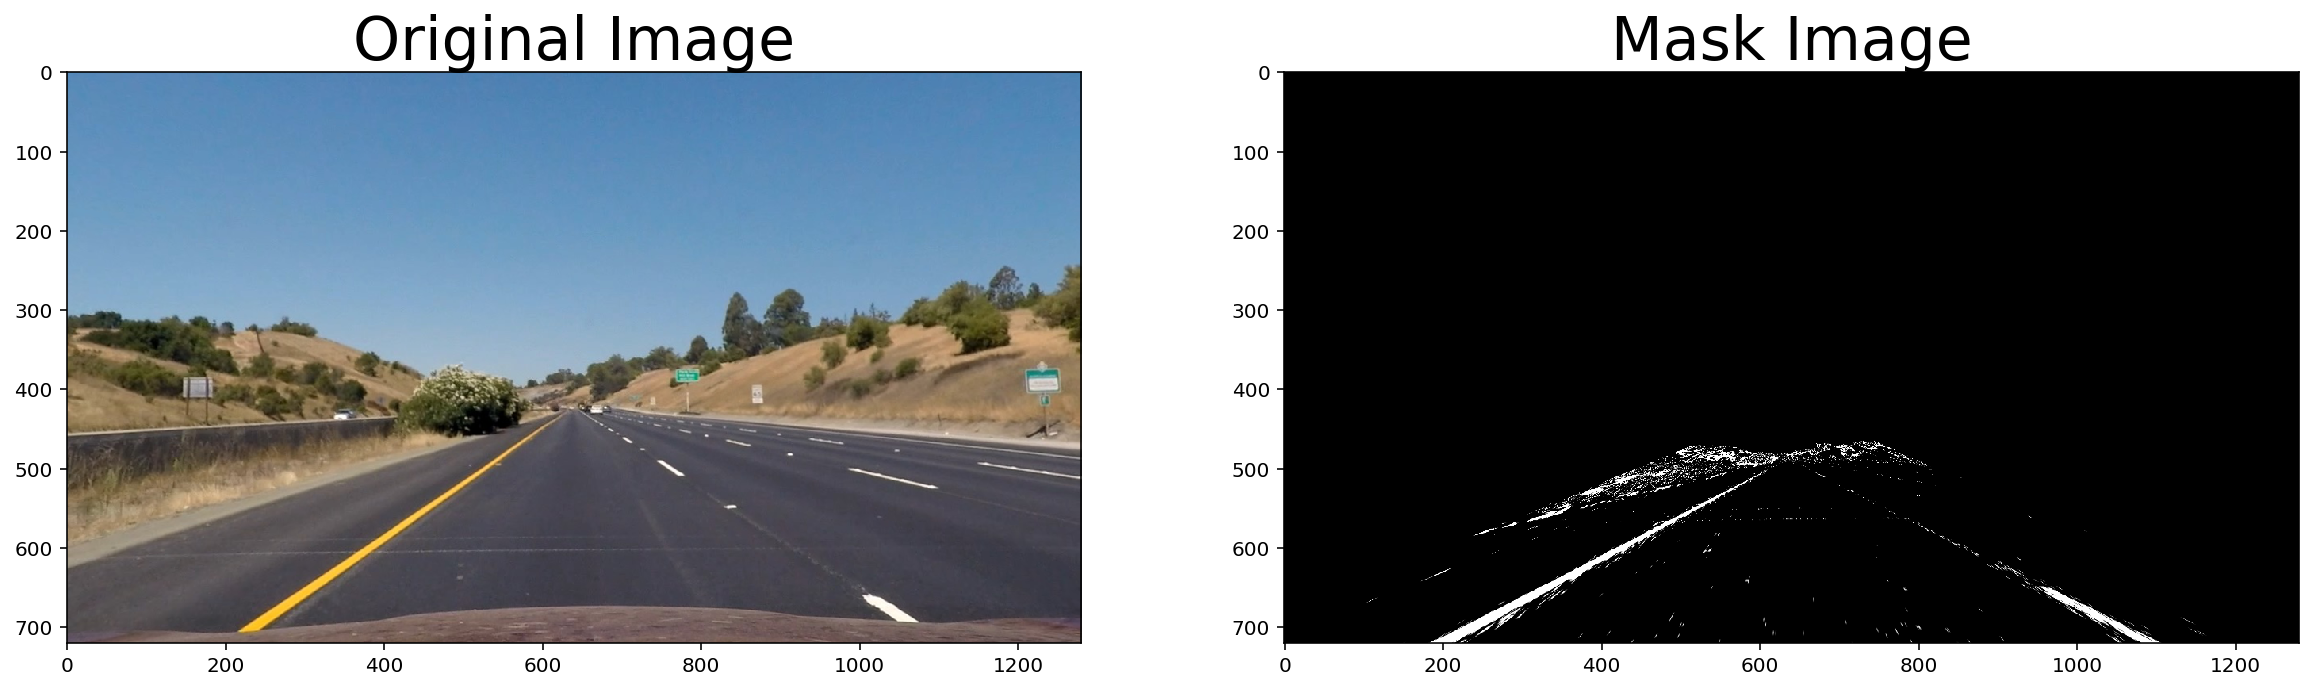

In [15]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = undistort(img)
warped = img #transform(img)




YellowHueMask = hls_mask(warped, component='H', thresh=(27 * 180 / 255, 34 * 180 / 255)) #yellow hue mask
warped_hue = img[:,:,0]
Vertical_Hue_Mask = gradient_direction_mask(warped_hue, thresh=(0, np.pi / 5)) #vertical gradient
Magnitude_Hue_Mask = gradient_magnitude_mask(warped_hue, thresh=(10, 100)) #magnitude gradient


#SaturationMask = hls_mask(warped, component='S', thresh=(190, 255)) #saturation mask
#WhiteHueMask = hls_mask(img, component='H', thresh=(15 * 180 / 255, 16 * 180 / 255)) #white hue mask

warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS) 
Vertical_Mask = gradient_direction_mask(warped_gray, thresh=(0, np.pi / 5)) #vertical gradient
Magnitude_Mask = gradient_magnitude_mask(warped_gray, thresh=(10, 100)) #magnitude gradient
S1 = mask_conjunction(Vertical_Hue_Mask,Magnitude_Hue_Mask)
S2 = mask_conjunction(Vertical_Mask,Magnitude_Mask)
S = S1 + S2
#S = reverse(S)
#mask1 = gradient_axis_mask(S, axis='x', sobel_kernel=3, thresh=(20, 30))
#mask2 = gradient_direction_mask(S, sobel_kernel=3, thresh=(0.01, 1.3))
#mask3 = gradient_axis_mask(cv2.cvtColor(cv2.cvtColor(warped, cv2.COLOR_HLS2BGR),cv2.COLOR_BGR2GRAY) , axis='x', sobel_kernel=3, thresh=(20, 100))


#mask = gradient_magnitude_mask(S, sobel_kernel=3, thresh=(20, 200))

mask = 255 * (S + SaturationMask)#mask_conjunction(mask1,mask2)
mask = reverse(mask)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mask, cmap='gray', vmin = 0, vmax = 255)
ax2.set_title('Mask Image', fontsize=30) 

 